In [5]:
import config_imports
from astropy import units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, TEME
from astropy.time import Time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


def to_datetime(eos_data: pd.DataFrame):
    eos_data["Datetime"] = eos_data[["Date", "Time", "Time since start (s)"]].apply(lambda x: datetime.datetime.fromisoformat(
        x.iloc[0] + "T" + x.iloc[1] + "Z") + datetime.timedelta(seconds=x.iloc[2] % 1.0), axis=1)
    eos_data = eos_data.drop(columns=["Date", "Time", "Time since start (s)"])
    return eos_data.set_index("Datetime", inplace=False)


eos_data_raw = pd.read_csv(r"EOS Sim Data\Sim1\sat_kinematic_state.CSV")


eos_data = eos_data_raw.drop(columns=["M11", "M12", "M13", "M21", "M22", "M23", "M31", "M32", "M33", 'M11.1', 'M12.1', 'M13.1', 'M21.1',
                                      'M22.1', 'M23.1', 'M31.1', 'M32.1', 'M33.1', 'X (deg/s).1', 'Y (deg/s).1', 'Z (deg/s).1'])

eos_data = to_datetime(eos_data)#.iloc[:10000, :]
time = eos_data.index
time_passed_hours = (time - time[0]).total_seconds()/(3600)

eos_data.columns

quat_OB = eos_data[['Q1', 'Q2', 'Q3', 'Q4']]
quat_OB /= np.linalg.norm(quat_OB, axis=1, keepdims=True)

omega_B_BI_deg = eos_data[['X (deg/s)', 'Y (deg/s)', 'Z (deg/s)']]

euler_OB = eos_data[['Roll (deg)', 'Pitch (deg)', 'Yaw (deg)']]

pos = eos_data[['X (km)', 'Y (km)', 'Z (km)']]
vel = eos_data[['X (km/s)', 'Y (km/s)', 'Z (km/s)']]

geocentric = eos_data[['Geocentric Latitude (deg)',
                       'Geodetic Latitude (deg)', 'Altitude (km)']]

orbit_elements = eos_data[['Eccentricity', 'Semi-major Axis (km)',
                           'Inclination (deg)', 'Right-ascension of Ascending Node (deg)',
                           'Argument of Perigee (deg)', 'True Anomaly (deg)',
                           'Radius of Perigee (km)', 'Radius of Apogee (km)',
                           'Perigee Altitude (km)', 'Apogee Altitude (km)']]

orbit_ang_rate = eos_data['Orbit Angular Rate (deg/s)']

# convert from TEME to GCRS inertial frame
def teme_to_gcrs(t: datetime.datetime, x_TEME):
    teme = TEME(obstime=Time(t, format="datetime", scale="utc"))
    x_ECI = SkyCoord(CartesianRepresentation(x_TEME[:, 0], x_TEME[:, 1], x_TEME[:, 2], unit=u.km), frame=teme,
                     representation_type='cartesian').transform_to("gcrs").cartesian.xyz.to(u.m).value  # type: ignore
    return x_ECI.T


pos_arr = teme_to_gcrs(time, np.array(pos))
vel_arr = teme_to_gcrs(time, np.array(vel))

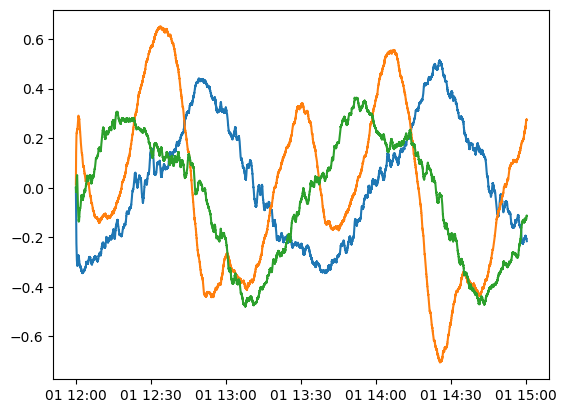

In [6]:
plt.plot(time, euler_OB)

In [ ]:
import json
import os
import config_imports
from dynamics import SGP4
from kinematics import euler_ocr_to_sbc
from utils import replace_orientation_matrices, string_to_matrix


eos_file_path = os.path.join(config_imports.PROJECT_DIR, "tudsat-trace_eos.json")
with open(eos_file_path, "r") as f:
    eos_file = json.load(f)

data: dict = replace_orientation_matrices(eos_file)  # type: ignore

settings = data["Settings"] # type: ignore
start = settings["SimulationStart"]

# If there's a "Z", change to +00:00, so the fromisoformat can always handle it
if isinstance(start, str) and start.endswith("Z"):
    start = start[:-1] + "+00:00"

t0 = datetime.datetime.fromisoformat(start)

# If there's going to be a time without timezone, forcefully take it as UTC
if t0.tzinfo is None:
    t0 = t0.replace(tzinfo=datetime.timezone.utc)

dt_ = tuple(map(float, settings["SimulationPeriod"].split(":")))
dt = datetime.timedelta(hours=dt_[0], minutes=dt_[1], seconds=dt_[2])

dur_ = tuple(map(int, settings["SimulationDuration"].split(":")))
dur = datetime.timedelta(hours=dur_[0], minutes=dur_[1], seconds=dur_[2])
tf = t0 + dur

kin_model = data["ModelObjects"]["Kinematic Model"] # type: ignore
roll = kin_model["InitialRoll"] # deg
pitch = kin_model["InitialPitch"]
yaw = kin_model["InitialYaw"]

init_ang_vel_B_BO = string_to_matrix(kin_model["InitialRates"])

init_att_BO = euler_ocr_to_sbc(roll, pitch, yaw)

tle1 = data["ModelObjects"]["Orbit Model"]["Tle1"] # type: ignore
tle2 = data["ModelObjects"]["Orbit Model"]["Tle2"] # type: ignore
orbit_model = SGP4.from_tle(tle1, tle2)
r_ECI, v_ECI = orbit_model.propagate(t0)

omega_0 = np.linalg.norm(v_ECI)/np.linalg.norm(r_ECI)
init_ang_vel_B_BI = init_ang_vel_B_BO + init_att_BO.apply(np.array((0, -omega_0, 0)))



In [ ]:
pd.DataFrame(np.rad2deg(omega_B))

In [ ]:
omega_B_BI_deg

In [ ]:
states = pd.read_csv(os.path.join(config_imports.PROJECT_DIR, "Simulation_2025-12-25_12-14-16", "state.csv"))


q_BI = states[["q_BI_x", "q_BI_y","q_BI_z","q_BI_w"]].to_numpy()
omega_B = states[["omega_x", "omega_y", "omega_z"]].to_numpy()